# Subsampling mocks
Using Mehdi's [code](https://github.com/mehdirezaie/LSSutils/blob/master/analysis/lssxcmb/scripts/subsample_mock.py).

In [1]:
import os
import numpy as np
import healpy as hp
from glob import glob
import fitsio as ft

# Run this script ONLY after running combine_nn_windows.py .
# nnwindow_*.hp{nside}.fits should be readable by hp.read_map, i.e. they should be healpix maps

nside = 256
windows = glob(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_*.hp{nside}.fits')

count = np.zeros(12*nside*nside)
wind = np.zeros(12*nside*nside) 

for window in windows:
    w = hp.read_map(window)
    is_seen = (w != hp.UNSEEN)
    wind[is_seen] += w[is_seen]  
    count[is_seen] += 1.0

is_good = count > 0.0
wind[is_good] = wind[is_good] / count[is_good]
wind[~is_good] = hp.UNSEEN
#print(f'wrote {output_path}')
#hp.write_map(output_path, wind_i, dtype=np.float64, fits_IDL=False, overwrite=True)

In [2]:
wind.min(), wind.max()

(-1.6375e+30, 37.895608850071625)

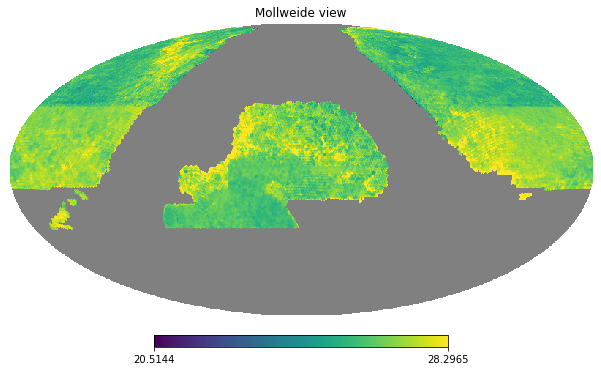

In [3]:
vlow, vhigh = np.percentile(wind, [1, 99])
hp.mollview(wind.clip(vlow,vhigh))

In [1]:
# %matplotlib inline
import healpy as hp
import numpy as np
import fitsio as ft
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def radec2hpix(nside, ra, dec):
    """ change ra,dec to HEALPix hpix with ring ordering """
    theta, phi = np.deg2rad(90.-dec), np.deg2rad(ra)
    hpix = hp.ang2pix(nside, theta, phi, nest=False)     
    return hpix

def project2hp(nside, mock, weight=None):
    """ count # of objects in HEALPix """
    ra = mock['RA']
    dec = mock['DEC']
    hpix = radec2hpix(nside, ra, dec)
    return np.bincount(hpix, weights=weight, minlength=12*nside*nside)

def downsample(selection_func, mock):
    """ downsample a mock catalog with a given selection function """
    nside = hp.get_nside(selection_func)
    hpix = radec2hpix(nside, mock['RA'], mock['DEC'])
    prob = selection_func[hpix]    
    good = np.random.uniform(size=mock.size) < prob
    return mock[good]



In [14]:
# read the mock catalog and selection function (obtained from real data)
#mock = ft.read('/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/')
ngal_pred = hp.read_map('/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_88.hp256.fits')

In [27]:
count = np.zeros(12*nside*nside)
wind = np.zeros(12*nside*nside) 
x = []
for i in range(2):
    w = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_{i}.hp256.fits')
    #print(ngal_pred[88888])
    is_seen = (w != hp.UNSEEN)
    wind[is_seen] += w[is_seen]  
    count[is_seen] += 1.0
    #x.append(ngal_pred[88888])
#print(np.array(x).mean())
is_good = count > 0.0
wind.min(), (wind[is_good]/count[is_good]).max()

(0.0, 32.098846435546875)

In [10]:
nside = 256
hpix = np.arange(0, 12*nside*nside, dtype='i8')

weights = glob('/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_*.hp256.fits')
print(len(weights))
windows = []
for weight in weights:
    w = hp.read_map(weight)
    #print(w.min(), w.max())
    #vlow, vhigh = np.percentile(w, [1, 99])
    #print(vlow, vhigh)
    #w = w.clip(vlow, vhigh)
    #print(w.min(), w.max())
    windows.append(w)
print(len(windows))
mean_window = np.mean(windows, axis=0)
mean_window.min(), mean_window.max(), mean_window.size

1000
1000


(-1.637499999999989e+30, 37.895608850071625, 786432)

In [18]:
hpix = np.arange(0, 12*nside*nside, dtype='i8')

In [19]:
wind1 = np.zeros(12*nside*nside)
print(wind1.min(), wind1.max())
wind1[hpix] += mean_window[hpix]

0.0 0.0


In [20]:
wind2 = np.zeros(12*nside*nside)
wind2[:] += mean_window[:]

In [21]:
np.array_equal(wind1, wind2)

True

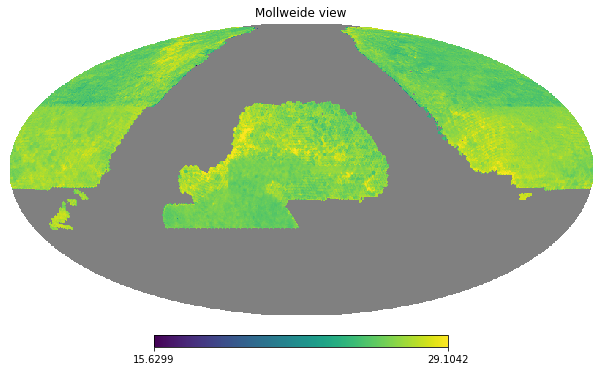

In [18]:
#ft.FITS('/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_983.hp256.fits')[1]
hp.mollview(mean_window)

In [5]:
# get nside from the selection function
nside = hp.get_nside(ngal_pred)

In [6]:
# normalize the selection function to [0, 1]
good = ngal_pred>0
vmin, vmax = np.percentile(ngal_pred[good], [0, 100])
selection_func = np.zeros_like(ngal_pred)
selection_func[good] = (ngal_pred[good]-vmin) / (vmax-vmin)

In [ ]:
# subsample the mock catalog, and project to HEALPix
mock_after = downsample(selection_func, mock)
mock_hp = project2hp(nside, mock)
mock_hp_after = project2hp(nside, mock_after)

In [ ]:
#
fig, ax = plt.subplots(nrows=3, figsize=(15, 20))
for i, (mapi, title) in enumerate(zip([mock_hp, selection_func, mock_hp_after],
                                      ['Clean Mock', 'Selection Func.', 'Cont. Mock'])):
    plt.sca(ax[i])        
    hp.mollview(mapi, title=title, hold=True, rot=-85)